In [1]:
import mysql_connection
import pandas as pd

# Function to convert string representation of overs to decimal
def convert_to_decimal(overs_str):
    if '.' in overs_str:
        overs, balls = overs_str.split('.')
        decimal_overs = int(overs) + int(balls) / 6
    else:
        decimal_overs = int(overs_str)
    return decimal_overs

def fetch_data(team, opposite_team, players, filter_field):
    # Get MySQL connection
    connection = mysql_connection.get_mysql_connection()

    if connection:
        # Initialize an empty list to store DataFrames for each player
        dfs = []

        # Loop through each player
        for player in players:
            if opposite_team == 'All':
                # SQL query to select specific fields from the table for the given player
                sql_query = f"""
                SELECT DISTINCT b.match_id, b.team, b.opposite_team, b.player, b.overs, b.{filter_field}, m.date
                FROM cricket_info.bowling AS b
                JOIN cricket_info.master AS m ON b.match_id = m.match_id
                WHERE b.team = %s AND b.player LIKE %s;
                """
                # Execute SQL query with parameters
                cursor = connection.cursor()
                cursor.execute(sql_query, (team, f'%{player}%'))
            
            else:
                # SQL query to select specific fields from the table for the given player
                sql_query = f"""
                SELECT DISTINCT b.match_id, b.team, b.opposite_team, b.player, b.overs, b.{filter_field}, m.date
                FROM cricket_info.bowling AS b
                JOIN cricket_info.master AS m ON b.match_id = m.match_id
                WHERE b.team = %s AND b.opposite_team = %s AND b.player LIKE %s;
                """
                # Execute SQL query with parameters
                cursor = connection.cursor()
                cursor.execute(sql_query, (team, opposite_team, f'%{player}%'))

            # Fetch all rows from the result set
            rows = cursor.fetchall()

            # Create DataFrame from fetched rows
            df = pd.DataFrame(rows, columns=['match_id', 'team', 'opposite_team', 'player', 'overs', filter_field, 'date'])

            # Print the column names
            print(f"Columns for player {player}: {df.columns}")

            # Convert 'runs' field to float
            df[filter_field] = df[filter_field].astype(float)

            # Apply the function to 'Overs' column
            df['overs'] = df['overs'].apply(convert_to_decimal)

            # Calculate total overs bowled in each match
            total_overs_per_match = df.groupby('match_id')['overs'].sum()

            # Calculate ratio of filter field to total overs for each match
            df['ratio'] = df[filter_field] / total_overs_per_match[df['match_id']].values

            # Append the DataFrame for the current player to the list
            dfs.append(df)

            # Close cursor
            cursor.close()

        # Close connection
        connection.close()
        
        return dfs
    else:
        print("Connection to the database failed.")
        return None


if __name__ == "__main__":
    team = 'New Zealand'
    opposite_team = 'Sri Lanka'
    # opposite_team = 'All'
    players = ['Tim Southee','Ish Sodhi']
    # players = ['Wanindu Hasaranga', 'Maheesh Theekshana','Tillakaratne Dilshan','Angelo Mathews']
    filter_field = 'runs'

    # Fetch data for multiple players
    dfs = fetch_data(team, opposite_team, players, filter_field)

    # Merge all players DataFrames into master_df
    master_df = pd.concat(dfs, ignore_index=True)

    master_df['date'] = pd.to_datetime(master_df['date'])
    
    # Sort DataFrame by 'date'
    master_df = master_df.sort_values(by='date', ascending=True)

    # # Plot data for multiple players
    # plot_data(master_df, players)

print(master_df)

Connected to MySQL database
Columns for player Tim Southee: Index(['match_id', 'team', 'opposite_team', 'player', 'overs', 'runs', 'date'], dtype='object')
Columns for player Ish Sodhi: Index(['match_id', 'team', 'opposite_team', 'player', 'overs', 'runs', 'date'], dtype='object')
       match_id         team opposite_team       player     overs  runs  \
3    T20I # 151  New Zealand     Sri Lanka  Tim Southee  4.000000  21.0   
6    T20I # 180  New Zealand     Sri Lanka  Tim Southee  3.000000  10.0   
5    T20I # 181  New Zealand     Sri Lanka  Tim Southee  1.000000  15.0   
4    T20I # 275  New Zealand     Sri Lanka  Tim Southee  4.000000  44.0   
11   T20I # 474  New Zealand     Sri Lanka    Ish Sodhi  4.000000  33.0   
8    T20I # 718  New Zealand     Sri Lanka  Tim Southee  2.000000  21.0   
16   T20I # 718  New Zealand     Sri Lanka    Ish Sodhi  3.833333  30.0   
7    T20I # 878  New Zealand     Sri Lanka  Tim Southee  4.000000  20.0   
13   T20I # 878  New Zealand     Sri Lanka 

Connected to MySQL database
Columns for player Wanindu Hasaranga: Index(['match_id', 'team', 'opposite_team', 'player', 'overs', 'runs', 'date'], dtype='object')
Columns for player Maheesh Theekshana: Index(['match_id', 'team', 'opposite_team', 'player', 'overs', 'runs', 'date'], dtype='object')
Columns for player Tillakaratne Dilshan: Index(['match_id', 'team', 'opposite_team', 'player', 'overs', 'runs', 'date'], dtype='object')
Columns for player Angelo Mathews: Index(['match_id', 'team', 'opposite_team', 'player', 'overs', 'runs', 'date'], dtype='object')


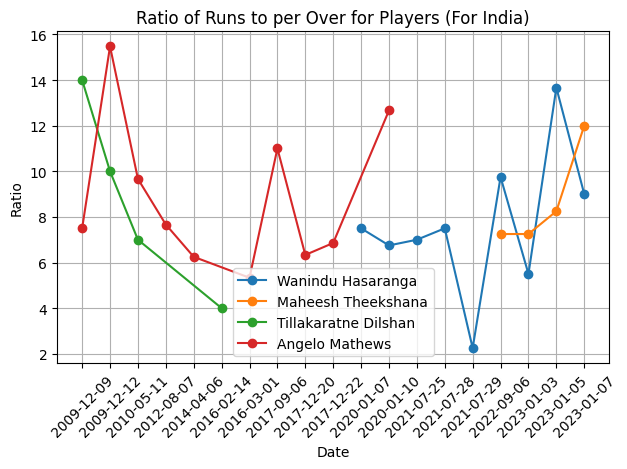

In [3]:
import mysql_connection
import pandas as pd
import matplotlib.pyplot as plt
import json

# Function to convert string representation of overs to decimal
def convert_to_decimal(overs_str):
    if '.' in overs_str:
        overs, balls = overs_str.split('.')
        decimal_overs = int(overs) + int(balls) / 6
    else:
        decimal_overs = int(overs_str)
    return decimal_overs


def fetch_data(team, opposite_team, players, filter_field):
    # Get MySQL connection
    connection = mysql_connection.get_mysql_connection()

    if connection:
        # Initialize an empty list to store DataFrames for each player
        dfs = []

        # Loop through each player
        for player in players:
            if opposite_team == 'All':
                # SQL query to select specific fields from the table for the given player
                sql_query = f"""
                SELECT DISTINCT b.match_id, b.team, b.opposite_team, b.player, b.overs, b.{filter_field}, m.date
                FROM cricket_info.bowling AS b
                JOIN cricket_info.master AS m ON b.match_id = m.match_id
                WHERE b.team = %s AND b.player LIKE %s;
                """
                # Execute SQL query with parameters
                cursor = connection.cursor()
                cursor.execute(sql_query, (team, f'%{player}%'))
            
            else:
                # SQL query to select specific fields from the table for the given player
                sql_query = f"""
                SELECT DISTINCT b.match_id, b.team, b.opposite_team, b.player, b.overs, b.{filter_field}, m.date
                FROM cricket_info.bowling AS b
                JOIN cricket_info.master AS m ON b.match_id = m.match_id
                WHERE b.team = %s AND b.opposite_team = %s AND b.player LIKE %s;
                """
                # Execute SQL query with parameters
                cursor = connection.cursor()
                cursor.execute(sql_query, (team, opposite_team, f'%{player}%'))

            # Fetch all rows from the result set
            rows = cursor.fetchall()

            # Create DataFrame from fetched rows
            df = pd.DataFrame(rows, columns=['match_id', 'team', 'opposite_team', 'player', 'overs', filter_field, 'date'])

            # Print the column names
            print(f"Columns for player {player}: {df.columns}")

            # Convert 'runs' field to float
            df[filter_field] = df[filter_field].astype(float)

            # Apply the function to 'Overs' column
            df['overs'] = df['overs'].apply(convert_to_decimal)

            # Calculate total overs bowled in each match
            total_overs_per_match = df.groupby('match_id')['overs'].sum()

            # Calculate ratio of filter field to total overs for each match
            df['ratio'] = df[filter_field] / total_overs_per_match[df['match_id']].values

            # Append the DataFrame for the current player to the list
            dfs.append(df)

            # Close cursor
            cursor.close()

        # Close connection
        connection.close()
        
        return dfs
    else:
        print("Connection to the database failed.")
        return None


import matplotlib.pyplot as plt
import pandas as pd

def plot_data(master_df, players): 
    # Convert 'date' column to datetime object
    master_df['date'] = pd.to_datetime(master_df['date'])
    
    # Create a DataFrame with unique dates and their corresponding sequential numbers
    unique_dates = master_df['date'].dt.date.unique()
    date_to_number = {date: i for i, date in enumerate(unique_dates)}
    
    # Data dictionary to store plotted data
    data_dict = {}
    
    # Iterate over each player
    for player in players:
        # Filter the DataFrame for the current player and create a copy
        player_df = master_df[master_df['player'] == player].copy()
        
        # Check if 'ratio' column exists in the DataFrame
        if 'ratio' in player_df.columns:
            # Map date to its sequential number
            player_df['date_number'] = player_df['date'].dt.date.map(date_to_number)
            
            plt.plot(player_df['date_number'], player_df['ratio'], marker='o', linestyle='-', label=player)

            # Store player data in dictionary
            data_dict[player] = {
                'date_number': player_df['date_number'].tolist(),
                'ratio': player_df['ratio'].tolist()
            }
        else:
            print(f"Warning: 'ratio' column not found in DataFrame for player {player}")

    plt.title(f'Ratio of {filter_field.capitalize()} to per Over for Players (For {opposite_team.capitalize()})')
    plt.xlabel('Date')
    plt.ylabel('Ratio')
    plt.legend()
    plt.xticks(ticks=range(len(unique_dates)), labels=unique_dates, rotation=45)  # Set x-axis ticks to unique dates
    plt.grid(True)
    plt.tight_layout()
    
    # Save the graph
    plt.savefig(f'Ratio of {filter_field.capitalize()} to per Over for Players (For {opposite_team.capitalize()})')
    
    # Save data to JSON file
    with open('output_file' + '.json', 'w') as f:
        json.dump(data_dict, f)

    
    plt.show()



if __name__ == "__main__":
    team = 'Sri Lanka'
    opposite_team = 'India'
    # opposite_team = 'All'
    players = ['Wanindu Hasaranga', 'Maheesh Theekshana','Tillakaratne Dilshan','Angelo Mathews']
    filter_field = 'runs'

    # Fetch data for multiple players
    dfs = fetch_data(team, opposite_team, players, filter_field)

    # Merge all players DataFrames into master_df
    master_df = pd.concat(dfs, ignore_index=True)

    master_df['date'] = pd.to_datetime(master_df['date'])
    
    # Sort DataFrame by 'date'
    master_df = master_df.sort_values(by='date', ascending=True)

    # Plot data for multiple players
    plot_data(master_df, players)


In [4]:
from bowling_random_forest_model import predict_player_performance

# Assuming 'master_df' is already loaded
player_name = 'Tim Southee'
mse = predict_player_performance(player_name, master_df)
print('Random ForestPredicted Ratio:', mse)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [2]:
from bowling_linear_regression_model import predict_player_performance

# Assuming 'master_df' is already loaded
player_name = 'Tim Southee'
mse = predict_player_performance(player_name, master_df)
print('Random ForestPredicted Ratio:', mse)


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [69]:
from bowling_SVR_model import predict_player_performance

# Assuming 'master_df' is already loaded
player_name = 'Tim Southee'
mse = predict_player_performance(player_name, master_df)
print('SVR Predicted Ratio:', mse)


Mean Squared Error: 0.002759532336682627
SVR Predicted Ratio: 0.002759532336682627


In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming you have the 'master_df' DataFrame containing the data
# You've already provided the data in the correct format

# Splitting the data into features (X) and target variable (y)
X = master_df[['overs', 'runs']]  # Features
y = master_df['ratio']             # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions using the linear regression model
linear_predictions = linear_model.predict(X_test)

# Evaluate the linear regression model
linear_mse = mean_squared_error(y_test, linear_predictions)
print('Linear Regression Mean Squared Error:', linear_mse)

# Initialize and train the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions using the Random Forest regression model
rf_predictions = rf_model.predict(X_test)

# Evaluate the Random Forest regression model
rf_mse = mean_squared_error(y_test, rf_predictions)
print('Random Forest Regression Mean Squared Error:', rf_mse)


Linear Regression Mean Squared Error: 3.2152154138008138
Random Forest Regression Mean Squared Error: 1.392546339385108
